In [1]:
import numpy as np
import random
import networkx as nx
from pygsp import graphs
import matplotlib.pyplot as plt

In [22]:
from synthetic_data.data_epidemics import epidemics_generator, genTrainData, generateInfectionMatrix

## Evaluating best graph to represent web propagation

### Barabasi-Albert

163 256


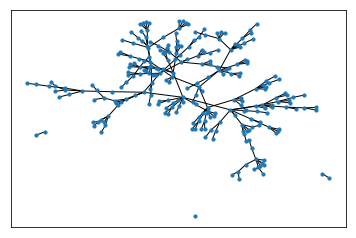

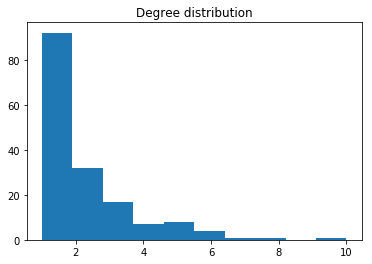

In [23]:
G = graphs.BarabasiAlbert(N=num_vertices, m0=6, m=1, seed=None)
G_nx = nx.from_numpy_matrix(G.W.todense())
nx.draw_networkx(G_nx,with_labels = False, node_size = 10)

Gcc = sorted(nx.connected_component_subgraphs(G_nx), key=len, reverse=True)
G0 = Gcc[0]
print(len(G0),len(G_nx))

plt.figure()
plt.title('Degree distribution')
plt.hist(np.array(nx.degree(G0))[:,1]);

The Barabasi-Albert model doesn't produce enough clustering though long-tailed distribution is more interesting.

### Community Graph

2019-10-15 17:48:09,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8284271247461903


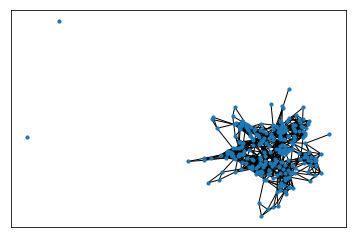

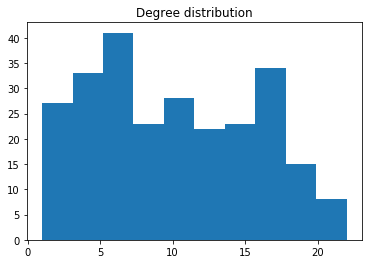

In [77]:
num_vertices = 256

# Initialize data

G = graphs.Community(num_vertices)#, seed=15)
G_nx = nx.from_numpy_matrix(G.W.todense())
nx.draw_networkx(G_nx,with_labels = False, node_size = 10)

Gcc = sorted(nx.connected_component_subgraphs(G_nx), key=len, reverse=True)
G0 = Gcc[0]
len(G0),len(G_nx)

plt.figure()
plt.title('Degree distribution')
plt.hist(np.array(nx.degree(G0))[:,1]);

# Experimenting with propagation model

In [78]:
beta, lambda_ = 0.003, 0.003
central = np.array(nx.degree(G0))[:,1].argmax()

initial_nodes = [central]
X = generateInfectionMatrix(G_nx,timesteps = 200,  beta=beta, lambda_=lambda_, initial_nodes = initial_nodes)

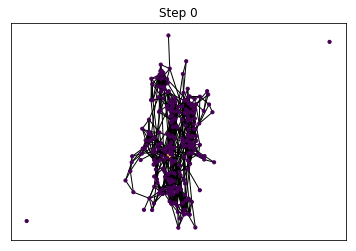

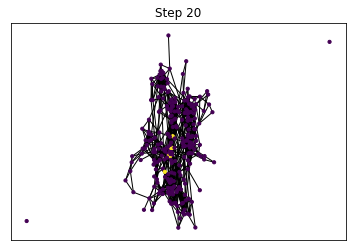

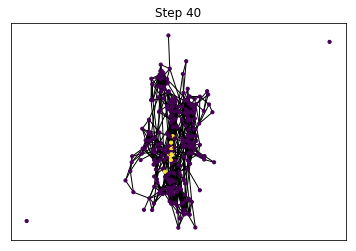

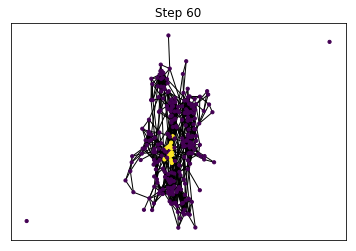

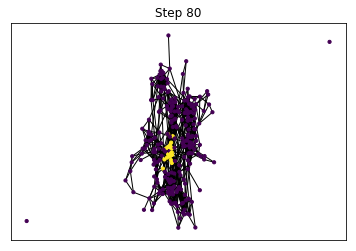

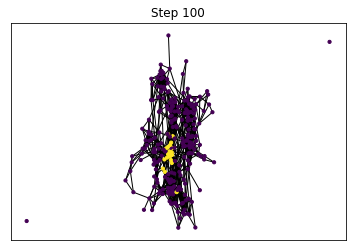

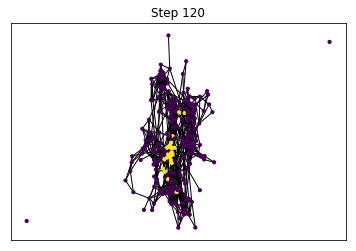

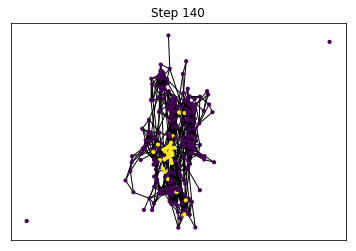

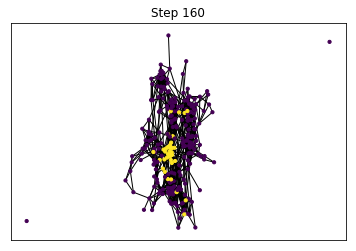

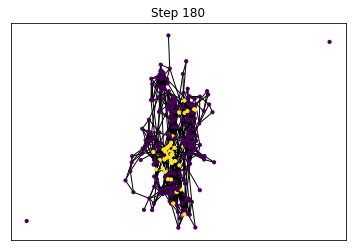

In [79]:
#visualization

pos = nx.spring_layout(G_nx)
for step in range(0,200,20):
    plt.figure()
    plt.title('Step {}'.format(step))
    nx.draw_networkx(G_nx,pos = pos, with_labels = False, node_size = 10, node_color = X[:,step])

In [68]:
central_nodes = np.argsort(np.array(nx.degree(G0))[:,1])[-6:]

In [171]:
from tqdm import tqdm_notebook as tqdm

def gen_n_samples(G,n, timesteps=100,cutoff = 50, samples = 3): 
    
    timesteps = timesteps
    cutoff = 50
    num_vertices = len(G)
    
    X = np.zeros((n,num_vertices,timesteps-cutoff,2*samples))
    Y = np.zeros((n,num_vertices))
    
    #for i in range(n):
    for i in tqdm(range(n)):
        #will have to start after some iterations
        

        beta, lambda_ = 0.005, 0.005
        sbeta = beta/100
        slambda = lambda_/100

        x = np.zeros((2*samples,num_vertices,timesteps))
        x[:samples],_ = genTrainData(G,beta,sbeta,lambda_,slambda, central_nodes[:2], samples, timesteps=timesteps,label=1)

        beta, lambda_ = 0.003, 0.004
        sbeta = beta/100
        slambda = lambda_/100
        x[samples:],_ = genTrainData(G,beta,sbeta,lambda_,slambda, central_nodes[2:], samples, timesteps=timesteps,label=0)

        #reshape and take off first iterations
        x = np.moveaxis(x, 0, -1)
        
        #y = node was infected?

        X[i]= x[:,cutoff:,:]
        Y[i]= ((x[:,:,:samples].sum(axis=(1,2))>0))
    
    return X.astype(int),Y.astype(int)

In [162]:
#1.10 sec per sample
X,Y = gen_n_samples(G_nx,1000, timesteps=150,cutoff = 50, samples = 3)

In [ ]:
Y.expand

In [163]:
np.save('multiX.npy',X)
np.save('multiY.npy',Y)

In [174]:
split = 0.8
n = int(split*len(X))

np.save('mulTrainData.npy',X[:n].astype(bool))
np.save('mulTrainLabels.npy',Y[:n].astype(bool))
np.save('mulTestData.npy' ,X[n:].astype(bool))
np.save('mulTestLabels.npy' ,Y[n:].astype(bool))

In [176]:
Y.shape

(1000, 256)

## Implementation

The idea was originally meant to have 6 news topic circulating around the graph from some of the central nodes. Some nodes were fake news hub and some were real news hub. The point was then to identify the nodes propagating the fake news through a fully convolutional architecture. However, there were problems in the implementation of fully convolutional nets, and while fixing them, I realized this just amounted to topic wise classification of fake/real news (solved already) then back tracing in the test data which nodes were infected by the fake news topic. The experiment framework did not allow for the TV-GCNN to help in a new way so the experiment was abandonned.

Alterations were made to the models.py in the signal classification as well as the test script (test_fullyconv)